In [1]:
import math
import numpy as np

import pandas as pd 
import scipy.io as io
import os 

from tqdm import tqdm

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Users\weightwater\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.deterministic = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
def train_valid_split(data_set, valid_ratio, seed):
    valid_dataset_size = int(len(data_set) * valid_ratio)
    train_dataset_size = len(data_set) - valid_dataset_size
    train_dataset, valid_dataset = random_split(data_set, [train_dataset_size, valid_dataset_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_dataset), np.array(valid_dataset)

def predict(test_loader, model, device):
    model.eval()
    preds = torch.Tensor([])
    for x in tqdm(test_loader):
        x = x.float().to(device)
        with torch.no_grad():
            pred = model(x)
            preds = torch.concat((preds, pred.detach().to('cpu')))
    return preds

In [3]:
class RespData(Dataset):

    def __init__(self, x):
        self.x = x
    
    def __getitem__(self, idx):
        return self.x[idx]
    
    def __len__(self):
        return len(self.x)
    

In [4]:
class LSTMAE(nn.Module):

    def __init__(self, inputDim, hidden_layer=32):
        super(LSTMAE, self).__init__()
        # self.batch_size = batch_size
        self.hidden_layer = 32

        self.encoder = nn.LSTM(inputDim, self.hidden_layer, batch_first=True)
        self.decoder = nn.LSTM(self.hidden_layer, inputDim, batch_first=True)

    def forward(self, x):
        x, (h, c) = self.encoder(x)
        x, (h, c) = self.decoder(x)
        return x

In [5]:
def trainer(train_loader, valid_loader, model, config, device):
    creterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

    writer = SummaryWriter()

    if not os.path.isdir('LSTMAE'):
        os.mkdir('./LSTMAE')
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], np.inf, 0, 0


    for epoch in range(n_epochs):    
        model.train()
        loss_record = []

        train_qbar = tqdm(train_loader, position=0, leave=True)

        for x in train_qbar:
            optimizer.zero_grad()
            x = x.float().to(device)
            prediction = model(x)
            # print(prediction.shape)
            loss = creterion(prediction, x)
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            loss_record.append(loss)

            train_qbar.set_description(f'Epoch [{epoch}/{n_epochs}]')
            train_qbar.set_postfix({'loss': loss.detach().item()})
        
        mean_train_loss = sum(loss_record) / len(loss_record)
        writer.add_scalar('LSTMAE_Loss/train', mean_train_loss, step)

        loss_record = []
        model.eval()
        for x in valid_loader:
            x = x.float().to(device)
            with torch.no_grad():
                pred = model(x)
                loss = creterion(pred, x)
            loss_record.append(loss)

        mean_valid_loss = sum(loss_record) / len(loss_record)
        print(f'Epoch [{epoch+1} / {n_epochs}]: Tain loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('LSTMAE_Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['best_model'])
            print(f'Saveing model with loss {best_loss:.3f} ...')
            early_stop_count = 0
        else:
            early_stop_count += 1
        
        if early_stop_count >= config['early_stop']:
            print('\nModel is not imporving, so we halt the training session')
            return
        
        torch.save(model.state_dict(), config['last_model'])
    writer.flush()
    writer.close()
            

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'learning_rate': 1e-3,
    'seed': 122914,
    'valid_ratio': 0.1,
    'early_stop': 400,
    'n_epochs': 10000,
    'best_model': './LSTMAE/lstm_best_0811.ckpt',
    'last_model': './LSTMAE/lstm_last_0811.ckpt',
    'step_size': 1000,
    'gamma': 0.99,
    'cellNumPDG': 371
}


In [7]:
a = np.empty([0, 3])
b = np.array([[1, 2, 3]])
a = np.append(a, b, axis=0)
a = np.concatenate((a, b))
print(a)

[[1. 2. 3.]
 [1. 2. 3.]]


In [8]:
def splitResp(RespData, stride=6):
    repeatNum, frameNum, cellNum = RespData.shape
    result = np.empty([0, stride, cellNum])
    for i in range(repeatNum):
        for j in range(frameNum-stride):
            result = np.concatenate((result, RespData[i:i+1, j:j+stride, :]))
    
    return result

- origin data shape like (repeat, frame, cellid)
- target data shape like (Number of Sequence, Number of Frames, Number of Cells)

In [9]:
same_seed(config['seed'])

frame_cell = 6*371

data = io.loadmat('./Main experiments/Mouse 1/RespData.mat')
PDG_data = data['RespData'][0][0][0][0][0][0][:, :, :, 0]
MOV_data = data['RespData'][0][0][1][0][0][0][:, :, :, 0]

repeatNumMOV, frameNumMOV, cellNumMOV = MOV_data.shape
MOV_data = MOV_data.reshape((repeatNumMOV * frameNumMOV, cellNumMOV))
MOV_data = (MOV_data - np.mean(MOV_data, axis=1, keepdims=True)) / np.std(MOV_data, axis=1, keepdims=True)
MOV_data = MOV_data.reshape((repeatNumMOV, frameNumMOV, cellNumMOV))

repeatNumPDG, frameNumPDG, cellNumPDG = PDG_data.shape
PDG_data = PDG_data.reshape((repeatNumPDG * frameNumPDG, cellNumPDG))
PDG_data = (PDG_data - np.mean(PDG_data, axis=1, keepdims=True)) / np.std(PDG_data, axis=1, keepdims=True)
PDG_data = PDG_data.reshape((repeatNumPDG, frameNumPDG, cellNumPDG))

# 处理数据格式符合LSTM，6frame，步长为1
# PDG_data = splitResp(PDG_data)
# MOV_data = splitResp(MOV_data)



In [8]:
PDG_data = np.load('./myData/PDG_data_split_LSTMAE.npy')
MOV_data = np.load('./myData/MOV_data_split_LSTMAE.npy')

In [9]:
train_data, valid_data = train_valid_split(PDG_data, config['valid_ratio'], config['seed'])
test_data = MOV_data

train_dataset, valid_dataset, test_dataset = RespData(train_data), RespData(valid_data), RespData(test_data)

train_loader, valid_loader = DataLoader(train_dataset, batch_size=16), DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset)

In [93]:
model = LSTMAE(inputDim=cellNumPDG).to(device)
# print(next(model.parameters()).device)
trainer(train_loader, valid_loader, model, config, device)

Epoch [0/10000]: 100%|██████████| 322/322 [00:01<00:00, 174.64it/s, loss=0.832]


Epoch [1 / 10000]: Tain loss: 0.8492, Valid loss: 0.7869
Saveing model with loss 0.787 ...


Epoch [1/10000]: 100%|██████████| 322/322 [00:01<00:00, 198.48it/s, loss=0.789]


Epoch [2 / 10000]: Tain loss: 0.7669, Valid loss: 0.7483
Saveing model with loss 0.748 ...


Epoch [2/10000]: 100%|██████████| 322/322 [00:01<00:00, 201.37it/s, loss=0.759]


Epoch [3 / 10000]: Tain loss: 0.7363, Valid loss: 0.7267
Saveing model with loss 0.727 ...


Epoch [3/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.10it/s, loss=0.738]


Epoch [4 / 10000]: Tain loss: 0.7179, Valid loss: 0.7134
Saveing model with loss 0.713 ...


Epoch [4/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.12it/s, loss=0.723]


Epoch [5 / 10000]: Tain loss: 0.7055, Valid loss: 0.7039
Saveing model with loss 0.704 ...


Epoch [5/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.28it/s, loss=0.711]


Epoch [6 / 10000]: Tain loss: 0.6963, Valid loss: 0.6968
Saveing model with loss 0.697 ...


Epoch [6/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.34it/s, loss=0.701]


Epoch [7 / 10000]: Tain loss: 0.6890, Valid loss: 0.6912
Saveing model with loss 0.691 ...


Epoch [7/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.77it/s, loss=0.692]


Epoch [8 / 10000]: Tain loss: 0.6830, Valid loss: 0.6867
Saveing model with loss 0.687 ...


Epoch [8/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.20it/s, loss=0.684]


Epoch [9 / 10000]: Tain loss: 0.6779, Valid loss: 0.6828
Saveing model with loss 0.683 ...


Epoch [9/10000]: 100%|██████████| 322/322 [00:01<00:00, 237.84it/s, loss=0.677]


Epoch [10 / 10000]: Tain loss: 0.6735, Valid loss: 0.6794
Saveing model with loss 0.679 ...


Epoch [10/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.49it/s, loss=0.671]


Epoch [11 / 10000]: Tain loss: 0.6696, Valid loss: 0.6764
Saveing model with loss 0.676 ...


Epoch [11/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.86it/s, loss=0.666]


Epoch [12 / 10000]: Tain loss: 0.6662, Valid loss: 0.6738
Saveing model with loss 0.674 ...


Epoch [12/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.67it/s, loss=0.661]


Epoch [13 / 10000]: Tain loss: 0.6631, Valid loss: 0.6715
Saveing model with loss 0.671 ...


Epoch [13/10000]: 100%|██████████| 322/322 [00:01<00:00, 215.55it/s, loss=0.656]


Epoch [14 / 10000]: Tain loss: 0.6604, Valid loss: 0.6695
Saveing model with loss 0.669 ...


Epoch [14/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.68it/s, loss=0.652]


Epoch [15 / 10000]: Tain loss: 0.6579, Valid loss: 0.6677
Saveing model with loss 0.668 ...


Epoch [15/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.36it/s, loss=0.649]


Epoch [16 / 10000]: Tain loss: 0.6555, Valid loss: 0.6661
Saveing model with loss 0.666 ...


Epoch [16/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.09it/s, loss=0.645]


Epoch [17 / 10000]: Tain loss: 0.6534, Valid loss: 0.6647
Saveing model with loss 0.665 ...


Epoch [17/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.66it/s, loss=0.642]


Epoch [18 / 10000]: Tain loss: 0.6515, Valid loss: 0.6634
Saveing model with loss 0.663 ...


Epoch [18/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.17it/s, loss=0.639]


Epoch [19 / 10000]: Tain loss: 0.6497, Valid loss: 0.6623
Saveing model with loss 0.662 ...


Epoch [19/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.04it/s, loss=0.636]


Epoch [20 / 10000]: Tain loss: 0.6481, Valid loss: 0.6614
Saveing model with loss 0.661 ...


Epoch [20/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.40it/s, loss=0.634]


Epoch [21 / 10000]: Tain loss: 0.6466, Valid loss: 0.6605
Saveing model with loss 0.661 ...


Epoch [21/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.51it/s, loss=0.631]


Epoch [22 / 10000]: Tain loss: 0.6452, Valid loss: 0.6598
Saveing model with loss 0.660 ...


Epoch [22/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.80it/s, loss=0.629]


Epoch [23 / 10000]: Tain loss: 0.6438, Valid loss: 0.6591
Saveing model with loss 0.659 ...


Epoch [23/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.88it/s, loss=0.627]


Epoch [24 / 10000]: Tain loss: 0.6426, Valid loss: 0.6585
Saveing model with loss 0.658 ...


Epoch [24/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.05it/s, loss=0.625]


Epoch [25 / 10000]: Tain loss: 0.6415, Valid loss: 0.6580
Saveing model with loss 0.658 ...


Epoch [25/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.59it/s, loss=0.623]


Epoch [26 / 10000]: Tain loss: 0.6404, Valid loss: 0.6575
Saveing model with loss 0.657 ...


Epoch [26/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.22it/s, loss=0.621]


Epoch [27 / 10000]: Tain loss: 0.6394, Valid loss: 0.6571
Saveing model with loss 0.657 ...


Epoch [27/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.95it/s, loss=0.62] 


Epoch [28 / 10000]: Tain loss: 0.6384, Valid loss: 0.6567
Saveing model with loss 0.657 ...


Epoch [28/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.46it/s, loss=0.618]


Epoch [29 / 10000]: Tain loss: 0.6375, Valid loss: 0.6564
Saveing model with loss 0.656 ...


Epoch [29/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.98it/s, loss=0.617]


Epoch [30 / 10000]: Tain loss: 0.6367, Valid loss: 0.6562
Saveing model with loss 0.656 ...


Epoch [30/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.11it/s, loss=0.615]


Epoch [31 / 10000]: Tain loss: 0.6359, Valid loss: 0.6559
Saveing model with loss 0.656 ...


Epoch [31/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.86it/s, loss=0.614]


Epoch [32 / 10000]: Tain loss: 0.6351, Valid loss: 0.6557
Saveing model with loss 0.656 ...


Epoch [32/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.54it/s, loss=0.613]


Epoch [33 / 10000]: Tain loss: 0.6344, Valid loss: 0.6555
Saveing model with loss 0.656 ...


Epoch [33/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.88it/s, loss=0.612]


Epoch [34 / 10000]: Tain loss: 0.6337, Valid loss: 0.6554
Saveing model with loss 0.655 ...


Epoch [34/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.38it/s, loss=0.61] 


Epoch [35 / 10000]: Tain loss: 0.6330, Valid loss: 0.6552
Saveing model with loss 0.655 ...


Epoch [35/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.41it/s, loss=0.609]


Epoch [36 / 10000]: Tain loss: 0.6324, Valid loss: 0.6551
Saveing model with loss 0.655 ...


Epoch [36/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.31it/s, loss=0.608]


Epoch [37 / 10000]: Tain loss: 0.6318, Valid loss: 0.6550
Saveing model with loss 0.655 ...


Epoch [37/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.37it/s, loss=0.607]


Epoch [38 / 10000]: Tain loss: 0.6312, Valid loss: 0.6549
Saveing model with loss 0.655 ...


Epoch [38/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.92it/s, loss=0.606]


Epoch [39 / 10000]: Tain loss: 0.6306, Valid loss: 0.6549
Saveing model with loss 0.655 ...


Epoch [39/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.82it/s, loss=0.605]


Epoch [40 / 10000]: Tain loss: 0.6301, Valid loss: 0.6548
Saveing model with loss 0.655 ...


Epoch [40/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.99it/s, loss=0.604]


Epoch [41 / 10000]: Tain loss: 0.6296, Valid loss: 0.6548
Saveing model with loss 0.655 ...


Epoch [41/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.64it/s, loss=0.603]


Epoch [42 / 10000]: Tain loss: 0.6291, Valid loss: 0.6548
Saveing model with loss 0.655 ...


Epoch [42/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.42it/s, loss=0.603]


Epoch [43 / 10000]: Tain loss: 0.6287, Valid loss: 0.6548


Epoch [43/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.03it/s, loss=0.602]


Epoch [44 / 10000]: Tain loss: 0.6283, Valid loss: 0.6547
Saveing model with loss 0.655 ...


Epoch [44/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.08it/s, loss=0.601]


Epoch [45 / 10000]: Tain loss: 0.6278, Valid loss: 0.6548


Epoch [45/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.79it/s, loss=0.601]


Epoch [46 / 10000]: Tain loss: 0.6275, Valid loss: 0.6547
Saveing model with loss 0.655 ...


Epoch [46/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.41it/s, loss=0.6]  


Epoch [47 / 10000]: Tain loss: 0.6271, Valid loss: 0.6549


Epoch [47/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.40it/s, loss=0.599]


Epoch [48 / 10000]: Tain loss: 0.6267, Valid loss: 0.6548


Epoch [48/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.22it/s, loss=0.599]


Epoch [49 / 10000]: Tain loss: 0.6263, Valid loss: 0.6549


Epoch [49/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.97it/s, loss=0.598]


Epoch [50 / 10000]: Tain loss: 0.6260, Valid loss: 0.6549


Epoch [50/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.21it/s, loss=0.598]


Epoch [51 / 10000]: Tain loss: 0.6257, Valid loss: 0.6549


Epoch [51/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.28it/s, loss=0.597]


Epoch [52 / 10000]: Tain loss: 0.6254, Valid loss: 0.6549


Epoch [52/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.50it/s, loss=0.597]


Epoch [53 / 10000]: Tain loss: 0.6251, Valid loss: 0.6550


Epoch [53/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.98it/s, loss=0.597]


Epoch [54 / 10000]: Tain loss: 0.6248, Valid loss: 0.6548


Epoch [54/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.60it/s, loss=0.596]


Epoch [55 / 10000]: Tain loss: 0.6245, Valid loss: 0.6550


Epoch [55/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.84it/s, loss=0.596]


Epoch [56 / 10000]: Tain loss: 0.6242, Valid loss: 0.6549


Epoch [56/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.17it/s, loss=0.595]


Epoch [57 / 10000]: Tain loss: 0.6238, Valid loss: 0.6550


Epoch [57/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.12it/s, loss=0.595]


Epoch [58 / 10000]: Tain loss: 0.6236, Valid loss: 0.6550


Epoch [58/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.64it/s, loss=0.594]


Epoch [59 / 10000]: Tain loss: 0.6233, Valid loss: 0.6551


Epoch [59/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.34it/s, loss=0.593]


Epoch [60 / 10000]: Tain loss: 0.6231, Valid loss: 0.6551


Epoch [60/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.09it/s, loss=0.593]


Epoch [61 / 10000]: Tain loss: 0.6229, Valid loss: 0.6551


Epoch [61/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.35it/s, loss=0.593]


Epoch [62 / 10000]: Tain loss: 0.6226, Valid loss: 0.6552


Epoch [62/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.32it/s, loss=0.592]


Epoch [63 / 10000]: Tain loss: 0.6224, Valid loss: 0.6552


Epoch [63/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.94it/s, loss=0.592]


Epoch [64 / 10000]: Tain loss: 0.6222, Valid loss: 0.6553


Epoch [64/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.02it/s, loss=0.592]


Epoch [65 / 10000]: Tain loss: 0.6220, Valid loss: 0.6553


Epoch [65/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.22it/s, loss=0.592]


Epoch [66 / 10000]: Tain loss: 0.6218, Valid loss: 0.6553


Epoch [66/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.15it/s, loss=0.592]


Epoch [67 / 10000]: Tain loss: 0.6215, Valid loss: 0.6555


Epoch [67/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.67it/s, loss=0.591]


Epoch [68 / 10000]: Tain loss: 0.6214, Valid loss: 0.6555


Epoch [68/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.27it/s, loss=0.591]


Epoch [69 / 10000]: Tain loss: 0.6212, Valid loss: 0.6554


Epoch [69/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.96it/s, loss=0.591]


Epoch [70 / 10000]: Tain loss: 0.6210, Valid loss: 0.6555


Epoch [70/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.35it/s, loss=0.591]


Epoch [71 / 10000]: Tain loss: 0.6208, Valid loss: 0.6556


Epoch [71/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.23it/s, loss=0.59] 


Epoch [72 / 10000]: Tain loss: 0.6207, Valid loss: 0.6556


Epoch [72/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.60it/s, loss=0.59] 


Epoch [73 / 10000]: Tain loss: 0.6204, Valid loss: 0.6558


Epoch [73/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.34it/s, loss=0.589]


Epoch [74 / 10000]: Tain loss: 0.6202, Valid loss: 0.6557


Epoch [74/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.10it/s, loss=0.589]


Epoch [75 / 10000]: Tain loss: 0.6200, Valid loss: 0.6558


Epoch [75/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.72it/s, loss=0.588]


Epoch [76 / 10000]: Tain loss: 0.6199, Valid loss: 0.6558


Epoch [76/10000]: 100%|██████████| 322/322 [00:01<00:00, 245.27it/s, loss=0.589]


Epoch [77 / 10000]: Tain loss: 0.6197, Valid loss: 0.6559


Epoch [77/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.41it/s, loss=0.588]


Epoch [78 / 10000]: Tain loss: 0.6196, Valid loss: 0.6559


Epoch [78/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.75it/s, loss=0.588]


Epoch [79 / 10000]: Tain loss: 0.6194, Valid loss: 0.6560


Epoch [79/10000]: 100%|██████████| 322/322 [00:01<00:00, 245.07it/s, loss=0.588]


Epoch [80 / 10000]: Tain loss: 0.6193, Valid loss: 0.6561


Epoch [80/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.53it/s, loss=0.588]


Epoch [81 / 10000]: Tain loss: 0.6192, Valid loss: 0.6560


Epoch [81/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.99it/s, loss=0.588]


Epoch [82 / 10000]: Tain loss: 0.6191, Valid loss: 0.6561


Epoch [82/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.30it/s, loss=0.587]


Epoch [83 / 10000]: Tain loss: 0.6189, Valid loss: 0.6562


Epoch [83/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.71it/s, loss=0.587]


Epoch [84 / 10000]: Tain loss: 0.6187, Valid loss: 0.6562


Epoch [84/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.38it/s, loss=0.587]


Epoch [85 / 10000]: Tain loss: 0.6186, Valid loss: 0.6563


Epoch [85/10000]: 100%|██████████| 322/322 [00:01<00:00, 240.92it/s, loss=0.587]


Epoch [86 / 10000]: Tain loss: 0.6185, Valid loss: 0.6564


Epoch [86/10000]: 100%|██████████| 322/322 [00:01<00:00, 237.67it/s, loss=0.586]


Epoch [87 / 10000]: Tain loss: 0.6184, Valid loss: 0.6566


Epoch [87/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.46it/s, loss=0.586]


Epoch [88 / 10000]: Tain loss: 0.6183, Valid loss: 0.6566


Epoch [88/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.18it/s, loss=0.586]


Epoch [89 / 10000]: Tain loss: 0.6181, Valid loss: 0.6565


Epoch [89/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.09it/s, loss=0.587]


Epoch [90 / 10000]: Tain loss: 0.6180, Valid loss: 0.6565


Epoch [90/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.00it/s, loss=0.587]


Epoch [91 / 10000]: Tain loss: 0.6178, Valid loss: 0.6567


Epoch [91/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.31it/s, loss=0.586]


Epoch [92 / 10000]: Tain loss: 0.6177, Valid loss: 0.6567


Epoch [92/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.26it/s, loss=0.587]


Epoch [93 / 10000]: Tain loss: 0.6176, Valid loss: 0.6568


Epoch [93/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.10it/s, loss=0.586]


Epoch [94 / 10000]: Tain loss: 0.6175, Valid loss: 0.6568


Epoch [94/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.18it/s, loss=0.586]


Epoch [95 / 10000]: Tain loss: 0.6174, Valid loss: 0.6568


Epoch [95/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.46it/s, loss=0.585]


Epoch [96 / 10000]: Tain loss: 0.6172, Valid loss: 0.6569


Epoch [96/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.28it/s, loss=0.585]


Epoch [97 / 10000]: Tain loss: 0.6171, Valid loss: 0.6569


Epoch [97/10000]: 100%|██████████| 322/322 [00:01<00:00, 246.39it/s, loss=0.585]


Epoch [98 / 10000]: Tain loss: 0.6169, Valid loss: 0.6571


Epoch [98/10000]: 100%|██████████| 322/322 [00:01<00:00, 246.96it/s, loss=0.585]


Epoch [99 / 10000]: Tain loss: 0.6168, Valid loss: 0.6571


Epoch [99/10000]: 100%|██████████| 322/322 [00:01<00:00, 245.54it/s, loss=0.585]


Epoch [100 / 10000]: Tain loss: 0.6167, Valid loss: 0.6572


Epoch [100/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.40it/s, loss=0.584]


Epoch [101 / 10000]: Tain loss: 0.6166, Valid loss: 0.6574


Epoch [101/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.98it/s, loss=0.584]


Epoch [102 / 10000]: Tain loss: 0.6165, Valid loss: 0.6573


Epoch [102/10000]: 100%|██████████| 322/322 [00:01<00:00, 247.84it/s, loss=0.584]


Epoch [103 / 10000]: Tain loss: 0.6163, Valid loss: 0.6575


Epoch [103/10000]: 100%|██████████| 322/322 [00:01<00:00, 248.18it/s, loss=0.584]


Epoch [104 / 10000]: Tain loss: 0.6162, Valid loss: 0.6575


Epoch [104/10000]: 100%|██████████| 322/322 [00:01<00:00, 250.04it/s, loss=0.584]


Epoch [105 / 10000]: Tain loss: 0.6161, Valid loss: 0.6576


Epoch [105/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.41it/s, loss=0.584]


Epoch [106 / 10000]: Tain loss: 0.6161, Valid loss: 0.6578


Epoch [106/10000]: 100%|██████████| 322/322 [00:01<00:00, 246.94it/s, loss=0.583]


Epoch [107 / 10000]: Tain loss: 0.6160, Valid loss: 0.6577


Epoch [107/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.14it/s, loss=0.583]


Epoch [108 / 10000]: Tain loss: 0.6159, Valid loss: 0.6577


Epoch [108/10000]: 100%|██████████| 322/322 [00:01<00:00, 244.27it/s, loss=0.584]


Epoch [109 / 10000]: Tain loss: 0.6159, Valid loss: 0.6578


Epoch [109/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.52it/s, loss=0.584]


Epoch [110 / 10000]: Tain loss: 0.6158, Valid loss: 0.6578


Epoch [110/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.37it/s, loss=0.583]


Epoch [111 / 10000]: Tain loss: 0.6156, Valid loss: 0.6578


Epoch [111/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.28it/s, loss=0.583]


Epoch [112 / 10000]: Tain loss: 0.6155, Valid loss: 0.6575


Epoch [112/10000]: 100%|██████████| 322/322 [00:01<00:00, 247.97it/s, loss=0.582]


Epoch [113 / 10000]: Tain loss: 0.6153, Valid loss: 0.6579


Epoch [113/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.35it/s, loss=0.583]


Epoch [114 / 10000]: Tain loss: 0.6153, Valid loss: 0.6579


Epoch [114/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.42it/s, loss=0.582]


Epoch [115 / 10000]: Tain loss: 0.6151, Valid loss: 0.6578


Epoch [115/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.79it/s, loss=0.583]


Epoch [116 / 10000]: Tain loss: 0.6151, Valid loss: 0.6579


Epoch [116/10000]: 100%|██████████| 322/322 [00:01<00:00, 228.81it/s, loss=0.583]


Epoch [117 / 10000]: Tain loss: 0.6149, Valid loss: 0.6581


Epoch [117/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.03it/s, loss=0.582]


Epoch [118 / 10000]: Tain loss: 0.6149, Valid loss: 0.6580


Epoch [118/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.72it/s, loss=0.582]


Epoch [119 / 10000]: Tain loss: 0.6148, Valid loss: 0.6580


Epoch [119/10000]: 100%|██████████| 322/322 [00:01<00:00, 229.11it/s, loss=0.583]


Epoch [120 / 10000]: Tain loss: 0.6147, Valid loss: 0.6581


Epoch [120/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.44it/s, loss=0.582]


Epoch [121 / 10000]: Tain loss: 0.6146, Valid loss: 0.6581


Epoch [121/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.58it/s, loss=0.582]


Epoch [122 / 10000]: Tain loss: 0.6146, Valid loss: 0.6582


Epoch [122/10000]: 100%|██████████| 322/322 [00:01<00:00, 190.80it/s, loss=0.582]


Epoch [123 / 10000]: Tain loss: 0.6144, Valid loss: 0.6582


Epoch [123/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.58it/s, loss=0.581]


Epoch [124 / 10000]: Tain loss: 0.6143, Valid loss: 0.6581


Epoch [124/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.78it/s, loss=0.582]


Epoch [125 / 10000]: Tain loss: 0.6142, Valid loss: 0.6582


Epoch [125/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.35it/s, loss=0.581]


Epoch [126 / 10000]: Tain loss: 0.6141, Valid loss: 0.6583


Epoch [126/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.45it/s, loss=0.581]


Epoch [127 / 10000]: Tain loss: 0.6141, Valid loss: 0.6584


Epoch [127/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.16it/s, loss=0.581]


Epoch [128 / 10000]: Tain loss: 0.6141, Valid loss: 0.6585


Epoch [128/10000]: 100%|██████████| 322/322 [00:01<00:00, 215.64it/s, loss=0.581]


Epoch [129 / 10000]: Tain loss: 0.6139, Valid loss: 0.6584


Epoch [129/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.06it/s, loss=0.58] 


Epoch [130 / 10000]: Tain loss: 0.6138, Valid loss: 0.6585


Epoch [130/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.27it/s, loss=0.581]


Epoch [131 / 10000]: Tain loss: 0.6137, Valid loss: 0.6588


Epoch [131/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.10it/s, loss=0.58] 


Epoch [132 / 10000]: Tain loss: 0.6136, Valid loss: 0.6586


Epoch [132/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.26it/s, loss=0.581]


Epoch [133 / 10000]: Tain loss: 0.6136, Valid loss: 0.6587


Epoch [133/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.89it/s, loss=0.58] 


Epoch [134 / 10000]: Tain loss: 0.6135, Valid loss: 0.6587


Epoch [134/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.39it/s, loss=0.581]


Epoch [135 / 10000]: Tain loss: 0.6135, Valid loss: 0.6587


Epoch [135/10000]: 100%|██████████| 322/322 [00:01<00:00, 231.54it/s, loss=0.581]


Epoch [136 / 10000]: Tain loss: 0.6134, Valid loss: 0.6589


Epoch [136/10000]: 100%|██████████| 322/322 [00:01<00:00, 239.78it/s, loss=0.581]


Epoch [137 / 10000]: Tain loss: 0.6133, Valid loss: 0.6588


Epoch [137/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.68it/s, loss=0.581]


Epoch [138 / 10000]: Tain loss: 0.6132, Valid loss: 0.6590


Epoch [138/10000]: 100%|██████████| 322/322 [00:01<00:00, 231.26it/s, loss=0.58] 


Epoch [139 / 10000]: Tain loss: 0.6132, Valid loss: 0.6590


Epoch [139/10000]: 100%|██████████| 322/322 [00:01<00:00, 244.28it/s, loss=0.58] 


Epoch [140 / 10000]: Tain loss: 0.6131, Valid loss: 0.6590


Epoch [140/10000]: 100%|██████████| 322/322 [00:01<00:00, 247.37it/s, loss=0.58] 


Epoch [141 / 10000]: Tain loss: 0.6130, Valid loss: 0.6591


Epoch [141/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.98it/s, loss=0.58] 


Epoch [142 / 10000]: Tain loss: 0.6129, Valid loss: 0.6590


Epoch [142/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.90it/s, loss=0.58] 


Epoch [143 / 10000]: Tain loss: 0.6128, Valid loss: 0.6592


Epoch [143/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.99it/s, loss=0.579]


Epoch [144 / 10000]: Tain loss: 0.6127, Valid loss: 0.6593


Epoch [144/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.42it/s, loss=0.58] 


Epoch [145 / 10000]: Tain loss: 0.6127, Valid loss: 0.6594


Epoch [145/10000]: 100%|██████████| 322/322 [00:01<00:00, 237.41it/s, loss=0.58] 


Epoch [146 / 10000]: Tain loss: 0.6126, Valid loss: 0.6594


Epoch [146/10000]: 100%|██████████| 322/322 [00:01<00:00, 237.41it/s, loss=0.579]


Epoch [147 / 10000]: Tain loss: 0.6126, Valid loss: 0.6593


Epoch [147/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.30it/s, loss=0.579]


Epoch [148 / 10000]: Tain loss: 0.6125, Valid loss: 0.6597


Epoch [148/10000]: 100%|██████████| 322/322 [00:01<00:00, 203.94it/s, loss=0.579]


Epoch [149 / 10000]: Tain loss: 0.6124, Valid loss: 0.6596


Epoch [149/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.78it/s, loss=0.579]


Epoch [150 / 10000]: Tain loss: 0.6124, Valid loss: 0.6596


Epoch [150/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.55it/s, loss=0.579]


Epoch [151 / 10000]: Tain loss: 0.6124, Valid loss: 0.6598


Epoch [151/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.16it/s, loss=0.579]


Epoch [152 / 10000]: Tain loss: 0.6122, Valid loss: 0.6597


Epoch [152/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.91it/s, loss=0.579]


Epoch [153 / 10000]: Tain loss: 0.6122, Valid loss: 0.6597


Epoch [153/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.65it/s, loss=0.578]


Epoch [154 / 10000]: Tain loss: 0.6121, Valid loss: 0.6600


Epoch [154/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.44it/s, loss=0.579]


Epoch [155 / 10000]: Tain loss: 0.6120, Valid loss: 0.6600


Epoch [155/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.27it/s, loss=0.579]


Epoch [156 / 10000]: Tain loss: 0.6120, Valid loss: 0.6601


Epoch [156/10000]: 100%|██████████| 322/322 [00:01<00:00, 239.32it/s, loss=0.578]


Epoch [157 / 10000]: Tain loss: 0.6119, Valid loss: 0.6602


Epoch [157/10000]: 100%|██████████| 322/322 [00:01<00:00, 229.26it/s, loss=0.578]


Epoch [158 / 10000]: Tain loss: 0.6119, Valid loss: 0.6603


Epoch [158/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.46it/s, loss=0.578]


Epoch [159 / 10000]: Tain loss: 0.6119, Valid loss: 0.6603


Epoch [159/10000]: 100%|██████████| 322/322 [00:01<00:00, 242.79it/s, loss=0.578]


Epoch [160 / 10000]: Tain loss: 0.6117, Valid loss: 0.6603


Epoch [160/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.46it/s, loss=0.578]


Epoch [161 / 10000]: Tain loss: 0.6116, Valid loss: 0.6606


Epoch [161/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.11it/s, loss=0.578]


Epoch [162 / 10000]: Tain loss: 0.6116, Valid loss: 0.6604


Epoch [162/10000]: 100%|██████████| 322/322 [00:01<00:00, 249.14it/s, loss=0.578]


Epoch [163 / 10000]: Tain loss: 0.6116, Valid loss: 0.6607


Epoch [163/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.61it/s, loss=0.578]


Epoch [164 / 10000]: Tain loss: 0.6115, Valid loss: 0.6606


Epoch [164/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.19it/s, loss=0.578]


Epoch [165 / 10000]: Tain loss: 0.6114, Valid loss: 0.6609


Epoch [165/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.55it/s, loss=0.578]


Epoch [166 / 10000]: Tain loss: 0.6114, Valid loss: 0.6607


Epoch [166/10000]: 100%|██████████| 322/322 [00:01<00:00, 242.89it/s, loss=0.578]


Epoch [167 / 10000]: Tain loss: 0.6114, Valid loss: 0.6608


Epoch [167/10000]: 100%|██████████| 322/322 [00:01<00:00, 237.81it/s, loss=0.578]


Epoch [168 / 10000]: Tain loss: 0.6114, Valid loss: 0.6609


Epoch [168/10000]: 100%|██████████| 322/322 [00:01<00:00, 240.38it/s, loss=0.578]


Epoch [169 / 10000]: Tain loss: 0.6113, Valid loss: 0.6608


Epoch [169/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.66it/s, loss=0.578]


Epoch [170 / 10000]: Tain loss: 0.6111, Valid loss: 0.6608


Epoch [170/10000]: 100%|██████████| 322/322 [00:01<00:00, 243.65it/s, loss=0.577]


Epoch [171 / 10000]: Tain loss: 0.6110, Valid loss: 0.6609


Epoch [171/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.76it/s, loss=0.577]


Epoch [172 / 10000]: Tain loss: 0.6110, Valid loss: 0.6609


Epoch [172/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.22it/s, loss=0.577]


Epoch [173 / 10000]: Tain loss: 0.6110, Valid loss: 0.6611


Epoch [173/10000]: 100%|██████████| 322/322 [00:01<00:00, 248.54it/s, loss=0.577]


Epoch [174 / 10000]: Tain loss: 0.6110, Valid loss: 0.6609


Epoch [174/10000]: 100%|██████████| 322/322 [00:01<00:00, 251.97it/s, loss=0.578]


Epoch [175 / 10000]: Tain loss: 0.6109, Valid loss: 0.6612


Epoch [175/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.61it/s, loss=0.577]


Epoch [176 / 10000]: Tain loss: 0.6108, Valid loss: 0.6610


Epoch [176/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.95it/s, loss=0.578]


Epoch [177 / 10000]: Tain loss: 0.6108, Valid loss: 0.6610


Epoch [177/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.67it/s, loss=0.577]


Epoch [178 / 10000]: Tain loss: 0.6107, Valid loss: 0.6611


Epoch [178/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.31it/s, loss=0.577]


Epoch [179 / 10000]: Tain loss: 0.6106, Valid loss: 0.6610


Epoch [179/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.77it/s, loss=0.577]


Epoch [180 / 10000]: Tain loss: 0.6106, Valid loss: 0.6613


Epoch [180/10000]: 100%|██████████| 322/322 [00:01<00:00, 249.83it/s, loss=0.577]


Epoch [181 / 10000]: Tain loss: 0.6106, Valid loss: 0.6613


Epoch [181/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.77it/s, loss=0.576]


Epoch [182 / 10000]: Tain loss: 0.6105, Valid loss: 0.6614


Epoch [182/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.57it/s, loss=0.577]


Epoch [183 / 10000]: Tain loss: 0.6105, Valid loss: 0.6613


Epoch [183/10000]: 100%|██████████| 322/322 [00:01<00:00, 232.99it/s, loss=0.576]


Epoch [184 / 10000]: Tain loss: 0.6104, Valid loss: 0.6614


Epoch [184/10000]: 100%|██████████| 322/322 [00:01<00:00, 255.31it/s, loss=0.576]


Epoch [185 / 10000]: Tain loss: 0.6103, Valid loss: 0.6614


Epoch [185/10000]: 100%|██████████| 322/322 [00:01<00:00, 253.36it/s, loss=0.577]


Epoch [186 / 10000]: Tain loss: 0.6103, Valid loss: 0.6614


Epoch [186/10000]: 100%|██████████| 322/322 [00:01<00:00, 251.43it/s, loss=0.577]


Epoch [187 / 10000]: Tain loss: 0.6103, Valid loss: 0.6616


Epoch [187/10000]: 100%|██████████| 322/322 [00:01<00:00, 246.17it/s, loss=0.577]


Epoch [188 / 10000]: Tain loss: 0.6102, Valid loss: 0.6616


Epoch [188/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.53it/s, loss=0.576]


Epoch [189 / 10000]: Tain loss: 0.6102, Valid loss: 0.6616


Epoch [189/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.05it/s, loss=0.576]


Epoch [190 / 10000]: Tain loss: 0.6101, Valid loss: 0.6615


Epoch [190/10000]: 100%|██████████| 322/322 [00:01<00:00, 247.57it/s, loss=0.576]


Epoch [191 / 10000]: Tain loss: 0.6100, Valid loss: 0.6617


Epoch [191/10000]: 100%|██████████| 322/322 [00:01<00:00, 244.42it/s, loss=0.576]


Epoch [192 / 10000]: Tain loss: 0.6100, Valid loss: 0.6619


Epoch [192/10000]: 100%|██████████| 322/322 [00:01<00:00, 247.58it/s, loss=0.577]


Epoch [193 / 10000]: Tain loss: 0.6100, Valid loss: 0.6618


Epoch [193/10000]: 100%|██████████| 322/322 [00:01<00:00, 248.55it/s, loss=0.576]


Epoch [194 / 10000]: Tain loss: 0.6099, Valid loss: 0.6619


Epoch [194/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.84it/s, loss=0.576]


Epoch [195 / 10000]: Tain loss: 0.6098, Valid loss: 0.6618


Epoch [195/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.10it/s, loss=0.576]


Epoch [196 / 10000]: Tain loss: 0.6098, Valid loss: 0.6619


Epoch [196/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.03it/s, loss=0.576]


Epoch [197 / 10000]: Tain loss: 0.6098, Valid loss: 0.6620


Epoch [197/10000]: 100%|██████████| 322/322 [00:01<00:00, 250.47it/s, loss=0.576]


Epoch [198 / 10000]: Tain loss: 0.6098, Valid loss: 0.6619


Epoch [198/10000]: 100%|██████████| 322/322 [00:01<00:00, 250.81it/s, loss=0.575]


Epoch [199 / 10000]: Tain loss: 0.6097, Valid loss: 0.6619


Epoch [199/10000]: 100%|██████████| 322/322 [00:01<00:00, 252.01it/s, loss=0.575]


Epoch [200 / 10000]: Tain loss: 0.6096, Valid loss: 0.6618


Epoch [200/10000]: 100%|██████████| 322/322 [00:01<00:00, 241.24it/s, loss=0.575]


Epoch [201 / 10000]: Tain loss: 0.6096, Valid loss: 0.6621


Epoch [201/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.54it/s, loss=0.576]


Epoch [202 / 10000]: Tain loss: 0.6095, Valid loss: 0.6620


Epoch [202/10000]: 100%|██████████| 322/322 [00:01<00:00, 239.17it/s, loss=0.575]


Epoch [203 / 10000]: Tain loss: 0.6095, Valid loss: 0.6622


Epoch [203/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.55it/s, loss=0.575]


Epoch [204 / 10000]: Tain loss: 0.6094, Valid loss: 0.6621


Epoch [204/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.28it/s, loss=0.575]


Epoch [205 / 10000]: Tain loss: 0.6094, Valid loss: 0.6621


Epoch [205/10000]: 100%|██████████| 322/322 [00:01<00:00, 240.49it/s, loss=0.574]


Epoch [206 / 10000]: Tain loss: 0.6093, Valid loss: 0.6621


Epoch [206/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.03it/s, loss=0.575]


Epoch [207 / 10000]: Tain loss: 0.6093, Valid loss: 0.6623


Epoch [207/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.42it/s, loss=0.575]


Epoch [208 / 10000]: Tain loss: 0.6093, Valid loss: 0.6623


Epoch [208/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.22it/s, loss=0.575]


Epoch [209 / 10000]: Tain loss: 0.6092, Valid loss: 0.6624


Epoch [209/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.56it/s, loss=0.575]


Epoch [210 / 10000]: Tain loss: 0.6092, Valid loss: 0.6625


Epoch [210/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.51it/s, loss=0.575]


Epoch [211 / 10000]: Tain loss: 0.6092, Valid loss: 0.6624


Epoch [211/10000]: 100%|██████████| 322/322 [00:01<00:00, 229.30it/s, loss=0.575]


Epoch [212 / 10000]: Tain loss: 0.6091, Valid loss: 0.6626


Epoch [212/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.03it/s, loss=0.574]


Epoch [213 / 10000]: Tain loss: 0.6090, Valid loss: 0.6624


Epoch [213/10000]: 100%|██████████| 322/322 [00:01<00:00, 245.37it/s, loss=0.576]


Epoch [214 / 10000]: Tain loss: 0.6090, Valid loss: 0.6627


Epoch [214/10000]: 100%|██████████| 322/322 [00:01<00:00, 210.79it/s, loss=0.575]


Epoch [215 / 10000]: Tain loss: 0.6089, Valid loss: 0.6626


Epoch [215/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.01it/s, loss=0.575]


Epoch [216 / 10000]: Tain loss: 0.6089, Valid loss: 0.6629


Epoch [216/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.04it/s, loss=0.575]


Epoch [217 / 10000]: Tain loss: 0.6088, Valid loss: 0.6626


Epoch [217/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.08it/s, loss=0.575]


Epoch [218 / 10000]: Tain loss: 0.6088, Valid loss: 0.6629


Epoch [218/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.70it/s, loss=0.574]


Epoch [219 / 10000]: Tain loss: 0.6087, Valid loss: 0.6628


Epoch [219/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.00it/s, loss=0.575]


Epoch [220 / 10000]: Tain loss: 0.6087, Valid loss: 0.6630


Epoch [220/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.67it/s, loss=0.575]


Epoch [221 / 10000]: Tain loss: 0.6088, Valid loss: 0.6628


Epoch [221/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.69it/s, loss=0.575]


Epoch [222 / 10000]: Tain loss: 0.6087, Valid loss: 0.6630


Epoch [222/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.71it/s, loss=0.574]


Epoch [223 / 10000]: Tain loss: 0.6086, Valid loss: 0.6629


Epoch [223/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.10it/s, loss=0.574]


Epoch [224 / 10000]: Tain loss: 0.6086, Valid loss: 0.6629


Epoch [224/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.25it/s, loss=0.574]


Epoch [225 / 10000]: Tain loss: 0.6084, Valid loss: 0.6630


Epoch [225/10000]: 100%|██████████| 322/322 [00:01<00:00, 199.47it/s, loss=0.574]


Epoch [226 / 10000]: Tain loss: 0.6084, Valid loss: 0.6628


Epoch [226/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.35it/s, loss=0.574]


Epoch [227 / 10000]: Tain loss: 0.6085, Valid loss: 0.6630


Epoch [227/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.82it/s, loss=0.574]


Epoch [228 / 10000]: Tain loss: 0.6084, Valid loss: 0.6631


Epoch [228/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.29it/s, loss=0.574]


Epoch [229 / 10000]: Tain loss: 0.6084, Valid loss: 0.6630


Epoch [229/10000]: 100%|██████████| 322/322 [00:01<00:00, 209.52it/s, loss=0.574]


Epoch [230 / 10000]: Tain loss: 0.6083, Valid loss: 0.6631


Epoch [230/10000]: 100%|██████████| 322/322 [00:01<00:00, 191.31it/s, loss=0.574]


Epoch [231 / 10000]: Tain loss: 0.6083, Valid loss: 0.6630


Epoch [231/10000]: 100%|██████████| 322/322 [00:01<00:00, 190.44it/s, loss=0.574]


Epoch [232 / 10000]: Tain loss: 0.6082, Valid loss: 0.6632


Epoch [232/10000]: 100%|██████████| 322/322 [00:01<00:00, 210.68it/s, loss=0.573]


Epoch [233 / 10000]: Tain loss: 0.6082, Valid loss: 0.6633


Epoch [233/10000]: 100%|██████████| 322/322 [00:01<00:00, 209.66it/s, loss=0.574]


Epoch [234 / 10000]: Tain loss: 0.6082, Valid loss: 0.6632


Epoch [234/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.68it/s, loss=0.574]


Epoch [235 / 10000]: Tain loss: 0.6081, Valid loss: 0.6633


Epoch [235/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.41it/s, loss=0.574]


Epoch [236 / 10000]: Tain loss: 0.6081, Valid loss: 0.6632


Epoch [236/10000]: 100%|██████████| 322/322 [00:01<00:00, 210.59it/s, loss=0.573]


Epoch [237 / 10000]: Tain loss: 0.6081, Valid loss: 0.6634


Epoch [237/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.09it/s, loss=0.573]


Epoch [238 / 10000]: Tain loss: 0.6080, Valid loss: 0.6634


Epoch [238/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.00it/s, loss=0.573]


Epoch [239 / 10000]: Tain loss: 0.6079, Valid loss: 0.6632


Epoch [239/10000]: 100%|██████████| 322/322 [00:01<00:00, 213.68it/s, loss=0.573]


Epoch [240 / 10000]: Tain loss: 0.6079, Valid loss: 0.6633


Epoch [240/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.51it/s, loss=0.573]


Epoch [241 / 10000]: Tain loss: 0.6079, Valid loss: 0.6634


Epoch [241/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.39it/s, loss=0.573]


Epoch [242 / 10000]: Tain loss: 0.6079, Valid loss: 0.6634


Epoch [242/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.40it/s, loss=0.573]


Epoch [243 / 10000]: Tain loss: 0.6078, Valid loss: 0.6635


Epoch [243/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.31it/s, loss=0.573]


Epoch [244 / 10000]: Tain loss: 0.6078, Valid loss: 0.6634


Epoch [244/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.45it/s, loss=0.573]


Epoch [245 / 10000]: Tain loss: 0.6077, Valid loss: 0.6636


Epoch [245/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.08it/s, loss=0.573]


Epoch [246 / 10000]: Tain loss: 0.6077, Valid loss: 0.6636


Epoch [246/10000]: 100%|██████████| 322/322 [00:01<00:00, 213.44it/s, loss=0.573]


Epoch [247 / 10000]: Tain loss: 0.6076, Valid loss: 0.6638


Epoch [247/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.71it/s, loss=0.573]


Epoch [248 / 10000]: Tain loss: 0.6076, Valid loss: 0.6636


Epoch [248/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.79it/s, loss=0.573]


Epoch [249 / 10000]: Tain loss: 0.6076, Valid loss: 0.6636


Epoch [249/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.78it/s, loss=0.572]


Epoch [250 / 10000]: Tain loss: 0.6075, Valid loss: 0.6638


Epoch [250/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.77it/s, loss=0.573]


Epoch [251 / 10000]: Tain loss: 0.6075, Valid loss: 0.6637


Epoch [251/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.75it/s, loss=0.573]


Epoch [252 / 10000]: Tain loss: 0.6075, Valid loss: 0.6639


Epoch [252/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.11it/s, loss=0.572]


Epoch [253 / 10000]: Tain loss: 0.6075, Valid loss: 0.6640


Epoch [253/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.28it/s, loss=0.572]


Epoch [254 / 10000]: Tain loss: 0.6074, Valid loss: 0.6638


Epoch [254/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.80it/s, loss=0.572]


Epoch [255 / 10000]: Tain loss: 0.6074, Valid loss: 0.6639


Epoch [255/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.40it/s, loss=0.573]


Epoch [256 / 10000]: Tain loss: 0.6073, Valid loss: 0.6641


Epoch [256/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.71it/s, loss=0.573]


Epoch [257 / 10000]: Tain loss: 0.6073, Valid loss: 0.6641


Epoch [257/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.96it/s, loss=0.573]


Epoch [258 / 10000]: Tain loss: 0.6073, Valid loss: 0.6642


Epoch [258/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.98it/s, loss=0.572]


Epoch [259 / 10000]: Tain loss: 0.6073, Valid loss: 0.6641


Epoch [259/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.73it/s, loss=0.572]


Epoch [260 / 10000]: Tain loss: 0.6072, Valid loss: 0.6643


Epoch [260/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.28it/s, loss=0.572]


Epoch [261 / 10000]: Tain loss: 0.6072, Valid loss: 0.6640


Epoch [261/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.92it/s, loss=0.572]


Epoch [262 / 10000]: Tain loss: 0.6072, Valid loss: 0.6641


Epoch [262/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.45it/s, loss=0.572]


Epoch [263 / 10000]: Tain loss: 0.6071, Valid loss: 0.6642


Epoch [263/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.63it/s, loss=0.572]


Epoch [264 / 10000]: Tain loss: 0.6071, Valid loss: 0.6644


Epoch [264/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.38it/s, loss=0.572]


Epoch [265 / 10000]: Tain loss: 0.6070, Valid loss: 0.6645


Epoch [265/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.85it/s, loss=0.572]


Epoch [266 / 10000]: Tain loss: 0.6069, Valid loss: 0.6643


Epoch [266/10000]: 100%|██████████| 322/322 [00:01<00:00, 215.58it/s, loss=0.573]


Epoch [267 / 10000]: Tain loss: 0.6070, Valid loss: 0.6645


Epoch [267/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.39it/s, loss=0.572]


Epoch [268 / 10000]: Tain loss: 0.6070, Valid loss: 0.6643


Epoch [268/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.76it/s, loss=0.571]


Epoch [269 / 10000]: Tain loss: 0.6069, Valid loss: 0.6646


Epoch [269/10000]: 100%|██████████| 322/322 [00:01<00:00, 209.95it/s, loss=0.572]


Epoch [270 / 10000]: Tain loss: 0.6069, Valid loss: 0.6644


Epoch [270/10000]: 100%|██████████| 322/322 [00:01<00:00, 203.51it/s, loss=0.572]


Epoch [271 / 10000]: Tain loss: 0.6069, Valid loss: 0.6646


Epoch [271/10000]: 100%|██████████| 322/322 [00:01<00:00, 209.17it/s, loss=0.571]


Epoch [272 / 10000]: Tain loss: 0.6068, Valid loss: 0.6647


Epoch [272/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.00it/s, loss=0.571]


Epoch [273 / 10000]: Tain loss: 0.6067, Valid loss: 0.6647


Epoch [273/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.14it/s, loss=0.571]


Epoch [274 / 10000]: Tain loss: 0.6067, Valid loss: 0.6646


Epoch [274/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.90it/s, loss=0.571]


Epoch [275 / 10000]: Tain loss: 0.6067, Valid loss: 0.6647


Epoch [275/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.60it/s, loss=0.572]


Epoch [276 / 10000]: Tain loss: 0.6067, Valid loss: 0.6647


Epoch [276/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.77it/s, loss=0.572]


Epoch [277 / 10000]: Tain loss: 0.6067, Valid loss: 0.6649


Epoch [277/10000]: 100%|██████████| 322/322 [00:01<00:00, 208.54it/s, loss=0.571]


Epoch [278 / 10000]: Tain loss: 0.6066, Valid loss: 0.6647


Epoch [278/10000]: 100%|██████████| 322/322 [00:01<00:00, 213.52it/s, loss=0.572]


Epoch [279 / 10000]: Tain loss: 0.6066, Valid loss: 0.6648


Epoch [279/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.85it/s, loss=0.571]


Epoch [280 / 10000]: Tain loss: 0.6065, Valid loss: 0.6649


Epoch [280/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.00it/s, loss=0.572]


Epoch [281 / 10000]: Tain loss: 0.6065, Valid loss: 0.6649


Epoch [281/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.66it/s, loss=0.571]


Epoch [282 / 10000]: Tain loss: 0.6065, Valid loss: 0.6649


Epoch [282/10000]: 100%|██████████| 322/322 [00:01<00:00, 203.08it/s, loss=0.571]


Epoch [283 / 10000]: Tain loss: 0.6065, Valid loss: 0.6650


Epoch [283/10000]: 100%|██████████| 322/322 [00:01<00:00, 213.88it/s, loss=0.571]


Epoch [284 / 10000]: Tain loss: 0.6064, Valid loss: 0.6651


Epoch [284/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.31it/s, loss=0.571]


Epoch [285 / 10000]: Tain loss: 0.6064, Valid loss: 0.6650


Epoch [285/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.37it/s, loss=0.571]


Epoch [286 / 10000]: Tain loss: 0.6063, Valid loss: 0.6652


Epoch [286/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.30it/s, loss=0.571]


Epoch [287 / 10000]: Tain loss: 0.6063, Valid loss: 0.6652


Epoch [287/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.95it/s, loss=0.571]


Epoch [288 / 10000]: Tain loss: 0.6063, Valid loss: 0.6653


Epoch [288/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.63it/s, loss=0.571]


Epoch [289 / 10000]: Tain loss: 0.6063, Valid loss: 0.6652


Epoch [289/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.74it/s, loss=0.571]


Epoch [290 / 10000]: Tain loss: 0.6063, Valid loss: 0.6654


Epoch [290/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.32it/s, loss=0.571]


Epoch [291 / 10000]: Tain loss: 0.6062, Valid loss: 0.6654


Epoch [291/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.87it/s, loss=0.571]


Epoch [292 / 10000]: Tain loss: 0.6062, Valid loss: 0.6652


Epoch [292/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.37it/s, loss=0.571]


Epoch [293 / 10000]: Tain loss: 0.6062, Valid loss: 0.6654


Epoch [293/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.48it/s, loss=0.571]


Epoch [294 / 10000]: Tain loss: 0.6062, Valid loss: 0.6655


Epoch [294/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.57it/s, loss=0.571]


Epoch [295 / 10000]: Tain loss: 0.6061, Valid loss: 0.6656


Epoch [295/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.82it/s, loss=0.57] 


Epoch [296 / 10000]: Tain loss: 0.6061, Valid loss: 0.6656


Epoch [296/10000]: 100%|██████████| 322/322 [00:01<00:00, 209.43it/s, loss=0.571]


Epoch [297 / 10000]: Tain loss: 0.6061, Valid loss: 0.6656


Epoch [297/10000]: 100%|██████████| 322/322 [00:01<00:00, 206.55it/s, loss=0.571]


Epoch [298 / 10000]: Tain loss: 0.6060, Valid loss: 0.6655


Epoch [298/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.59it/s, loss=0.57] 


Epoch [299 / 10000]: Tain loss: 0.6060, Valid loss: 0.6658


Epoch [299/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.95it/s, loss=0.571]


Epoch [300 / 10000]: Tain loss: 0.6060, Valid loss: 0.6656


Epoch [300/10000]: 100%|██████████| 322/322 [00:01<00:00, 206.43it/s, loss=0.571]


Epoch [301 / 10000]: Tain loss: 0.6060, Valid loss: 0.6659


Epoch [301/10000]: 100%|██████████| 322/322 [00:01<00:00, 206.43it/s, loss=0.571]


Epoch [302 / 10000]: Tain loss: 0.6059, Valid loss: 0.6655


Epoch [302/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.42it/s, loss=0.571]


Epoch [303 / 10000]: Tain loss: 0.6058, Valid loss: 0.6658


Epoch [303/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.40it/s, loss=0.571]


Epoch [304 / 10000]: Tain loss: 0.6058, Valid loss: 0.6657


Epoch [304/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.57it/s, loss=0.571]


Epoch [305 / 10000]: Tain loss: 0.6058, Valid loss: 0.6659


Epoch [305/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.55it/s, loss=0.57] 


Epoch [306 / 10000]: Tain loss: 0.6058, Valid loss: 0.6658


Epoch [306/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.33it/s, loss=0.57] 


Epoch [307 / 10000]: Tain loss: 0.6058, Valid loss: 0.6659


Epoch [307/10000]: 100%|██████████| 322/322 [00:01<00:00, 210.79it/s, loss=0.571]


Epoch [308 / 10000]: Tain loss: 0.6058, Valid loss: 0.6660


Epoch [308/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.90it/s, loss=0.57] 


Epoch [309 / 10000]: Tain loss: 0.6058, Valid loss: 0.6659


Epoch [309/10000]: 100%|██████████| 322/322 [00:01<00:00, 206.83it/s, loss=0.57] 


Epoch [310 / 10000]: Tain loss: 0.6056, Valid loss: 0.6661


Epoch [310/10000]: 100%|██████████| 322/322 [00:01<00:00, 213.73it/s, loss=0.57] 


Epoch [311 / 10000]: Tain loss: 0.6056, Valid loss: 0.6659


Epoch [311/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.98it/s, loss=0.57] 


Epoch [312 / 10000]: Tain loss: 0.6057, Valid loss: 0.6662


Epoch [312/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.84it/s, loss=0.571]


Epoch [313 / 10000]: Tain loss: 0.6056, Valid loss: 0.6660


Epoch [313/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.34it/s, loss=0.57] 


Epoch [314 / 10000]: Tain loss: 0.6056, Valid loss: 0.6661


Epoch [314/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.85it/s, loss=0.57] 


Epoch [315 / 10000]: Tain loss: 0.6055, Valid loss: 0.6662


Epoch [315/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.02it/s, loss=0.57] 


Epoch [316 / 10000]: Tain loss: 0.6055, Valid loss: 0.6663


Epoch [316/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.29it/s, loss=0.57] 


Epoch [317 / 10000]: Tain loss: 0.6055, Valid loss: 0.6663


Epoch [317/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.04it/s, loss=0.57] 


Epoch [318 / 10000]: Tain loss: 0.6055, Valid loss: 0.6663


Epoch [318/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.52it/s, loss=0.57] 


Epoch [319 / 10000]: Tain loss: 0.6054, Valid loss: 0.6662


Epoch [319/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.19it/s, loss=0.57] 


Epoch [320 / 10000]: Tain loss: 0.6054, Valid loss: 0.6664


Epoch [320/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.43it/s, loss=0.57] 


Epoch [321 / 10000]: Tain loss: 0.6054, Valid loss: 0.6665


Epoch [321/10000]: 100%|██████████| 322/322 [00:01<00:00, 196.25it/s, loss=0.571]


Epoch [322 / 10000]: Tain loss: 0.6053, Valid loss: 0.6665


Epoch [322/10000]: 100%|██████████| 322/322 [00:01<00:00, 200.09it/s, loss=0.57] 


Epoch [323 / 10000]: Tain loss: 0.6053, Valid loss: 0.6664


Epoch [323/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.77it/s, loss=0.57] 


Epoch [324 / 10000]: Tain loss: 0.6053, Valid loss: 0.6665


Epoch [324/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.41it/s, loss=0.569]


Epoch [325 / 10000]: Tain loss: 0.6053, Valid loss: 0.6665


Epoch [325/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.84it/s, loss=0.57] 


Epoch [326 / 10000]: Tain loss: 0.6053, Valid loss: 0.6664


Epoch [326/10000]: 100%|██████████| 322/322 [00:01<00:00, 210.04it/s, loss=0.57] 


Epoch [327 / 10000]: Tain loss: 0.6053, Valid loss: 0.6666


Epoch [327/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.29it/s, loss=0.57] 


Epoch [328 / 10000]: Tain loss: 0.6052, Valid loss: 0.6666


Epoch [328/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.29it/s, loss=0.569]


Epoch [329 / 10000]: Tain loss: 0.6052, Valid loss: 0.6666


Epoch [329/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.05it/s, loss=0.57] 


Epoch [330 / 10000]: Tain loss: 0.6051, Valid loss: 0.6666


Epoch [330/10000]: 100%|██████████| 322/322 [00:01<00:00, 199.71it/s, loss=0.57] 


Epoch [331 / 10000]: Tain loss: 0.6051, Valid loss: 0.6666


Epoch [331/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.02it/s, loss=0.569]


Epoch [332 / 10000]: Tain loss: 0.6051, Valid loss: 0.6667


Epoch [332/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.80it/s, loss=0.57] 


Epoch [333 / 10000]: Tain loss: 0.6051, Valid loss: 0.6666


Epoch [333/10000]: 100%|██████████| 322/322 [00:01<00:00, 189.88it/s, loss=0.569]


Epoch [334 / 10000]: Tain loss: 0.6050, Valid loss: 0.6667


Epoch [334/10000]: 100%|██████████| 322/322 [00:01<00:00, 198.69it/s, loss=0.569]


Epoch [335 / 10000]: Tain loss: 0.6051, Valid loss: 0.6667


Epoch [335/10000]: 100%|██████████| 322/322 [00:01<00:00, 202.26it/s, loss=0.569]


Epoch [336 / 10000]: Tain loss: 0.6051, Valid loss: 0.6668


Epoch [336/10000]: 100%|██████████| 322/322 [00:01<00:00, 206.70it/s, loss=0.569]


Epoch [337 / 10000]: Tain loss: 0.6050, Valid loss: 0.6667


Epoch [337/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.39it/s, loss=0.569]


Epoch [338 / 10000]: Tain loss: 0.6049, Valid loss: 0.6667


Epoch [338/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.22it/s, loss=0.57] 


Epoch [339 / 10000]: Tain loss: 0.6049, Valid loss: 0.6669


Epoch [339/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.14it/s, loss=0.569]


Epoch [340 / 10000]: Tain loss: 0.6049, Valid loss: 0.6668


Epoch [340/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.78it/s, loss=0.569]


Epoch [341 / 10000]: Tain loss: 0.6049, Valid loss: 0.6669


Epoch [341/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.00it/s, loss=0.57] 


Epoch [342 / 10000]: Tain loss: 0.6049, Valid loss: 0.6669


Epoch [342/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.62it/s, loss=0.569]


Epoch [343 / 10000]: Tain loss: 0.6048, Valid loss: 0.6668


Epoch [343/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.48it/s, loss=0.57] 


Epoch [344 / 10000]: Tain loss: 0.6048, Valid loss: 0.6669


Epoch [344/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.97it/s, loss=0.57] 


Epoch [345 / 10000]: Tain loss: 0.6048, Valid loss: 0.6669


Epoch [345/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.23it/s, loss=0.57] 


Epoch [346 / 10000]: Tain loss: 0.6048, Valid loss: 0.6670


Epoch [346/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.43it/s, loss=0.569]


Epoch [347 / 10000]: Tain loss: 0.6048, Valid loss: 0.6669


Epoch [347/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.85it/s, loss=0.569]


Epoch [348 / 10000]: Tain loss: 0.6047, Valid loss: 0.6670


Epoch [348/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.98it/s, loss=0.569]


Epoch [349 / 10000]: Tain loss: 0.6047, Valid loss: 0.6670


Epoch [349/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.60it/s, loss=0.569]


Epoch [350 / 10000]: Tain loss: 0.6047, Valid loss: 0.6671


Epoch [350/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.82it/s, loss=0.569]


Epoch [351 / 10000]: Tain loss: 0.6047, Valid loss: 0.6671


Epoch [351/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.04it/s, loss=0.569]


Epoch [352 / 10000]: Tain loss: 0.6046, Valid loss: 0.6671


Epoch [352/10000]: 100%|██████████| 322/322 [00:01<00:00, 212.95it/s, loss=0.569]


Epoch [353 / 10000]: Tain loss: 0.6045, Valid loss: 0.6671


Epoch [353/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.18it/s, loss=0.569]


Epoch [354 / 10000]: Tain loss: 0.6045, Valid loss: 0.6672


Epoch [354/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.25it/s, loss=0.569]


Epoch [355 / 10000]: Tain loss: 0.6045, Valid loss: 0.6672


Epoch [355/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.23it/s, loss=0.569]


Epoch [356 / 10000]: Tain loss: 0.6045, Valid loss: 0.6672


Epoch [356/10000]: 100%|██████████| 322/322 [00:01<00:00, 218.06it/s, loss=0.569]


Epoch [357 / 10000]: Tain loss: 0.6046, Valid loss: 0.6673


Epoch [357/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.67it/s, loss=0.569]


Epoch [358 / 10000]: Tain loss: 0.6045, Valid loss: 0.6672


Epoch [358/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.01it/s, loss=0.569]


Epoch [359 / 10000]: Tain loss: 0.6045, Valid loss: 0.6673


Epoch [359/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.46it/s, loss=0.569]


Epoch [360 / 10000]: Tain loss: 0.6045, Valid loss: 0.6673


Epoch [360/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.14it/s, loss=0.569]


Epoch [361 / 10000]: Tain loss: 0.6044, Valid loss: 0.6675


Epoch [361/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.81it/s, loss=0.569]


Epoch [362 / 10000]: Tain loss: 0.6044, Valid loss: 0.6675


Epoch [362/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.99it/s, loss=0.568]


Epoch [363 / 10000]: Tain loss: 0.6044, Valid loss: 0.6674


Epoch [363/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.19it/s, loss=0.569]


Epoch [364 / 10000]: Tain loss: 0.6044, Valid loss: 0.6676


Epoch [364/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.78it/s, loss=0.569]


Epoch [365 / 10000]: Tain loss: 0.6043, Valid loss: 0.6675


Epoch [365/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.59it/s, loss=0.569]


Epoch [366 / 10000]: Tain loss: 0.6043, Valid loss: 0.6676


Epoch [366/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.99it/s, loss=0.569]


Epoch [367 / 10000]: Tain loss: 0.6043, Valid loss: 0.6675


Epoch [367/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.70it/s, loss=0.568]


Epoch [368 / 10000]: Tain loss: 0.6042, Valid loss: 0.6677


Epoch [368/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.21it/s, loss=0.568]


Epoch [369 / 10000]: Tain loss: 0.6042, Valid loss: 0.6676


Epoch [369/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.83it/s, loss=0.569]


Epoch [370 / 10000]: Tain loss: 0.6042, Valid loss: 0.6677


Epoch [370/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.42it/s, loss=0.569]


Epoch [371 / 10000]: Tain loss: 0.6042, Valid loss: 0.6677


Epoch [371/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.16it/s, loss=0.569]


Epoch [372 / 10000]: Tain loss: 0.6042, Valid loss: 0.6678


Epoch [372/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.62it/s, loss=0.569]


Epoch [373 / 10000]: Tain loss: 0.6042, Valid loss: 0.6677


Epoch [373/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.50it/s, loss=0.568]


Epoch [374 / 10000]: Tain loss: 0.6041, Valid loss: 0.6679


Epoch [374/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.57it/s, loss=0.568]


Epoch [375 / 10000]: Tain loss: 0.6041, Valid loss: 0.6679


Epoch [375/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.49it/s, loss=0.568]


Epoch [376 / 10000]: Tain loss: 0.6041, Valid loss: 0.6679


Epoch [376/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.29it/s, loss=0.568]


Epoch [377 / 10000]: Tain loss: 0.6041, Valid loss: 0.6680


Epoch [377/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.49it/s, loss=0.568]


Epoch [378 / 10000]: Tain loss: 0.6041, Valid loss: 0.6680


Epoch [378/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.70it/s, loss=0.568]


Epoch [379 / 10000]: Tain loss: 0.6040, Valid loss: 0.6680


Epoch [379/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.57it/s, loss=0.568]


Epoch [380 / 10000]: Tain loss: 0.6040, Valid loss: 0.6681


Epoch [380/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.80it/s, loss=0.568]


Epoch [381 / 10000]: Tain loss: 0.6040, Valid loss: 0.6681


Epoch [381/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.73it/s, loss=0.568]


Epoch [382 / 10000]: Tain loss: 0.6040, Valid loss: 0.6682


Epoch [382/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.73it/s, loss=0.569]


Epoch [383 / 10000]: Tain loss: 0.6039, Valid loss: 0.6681


Epoch [383/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.78it/s, loss=0.568]


Epoch [384 / 10000]: Tain loss: 0.6039, Valid loss: 0.6682


Epoch [384/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.85it/s, loss=0.568]


Epoch [385 / 10000]: Tain loss: 0.6039, Valid loss: 0.6682


Epoch [385/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.99it/s, loss=0.568]


Epoch [386 / 10000]: Tain loss: 0.6039, Valid loss: 0.6682


Epoch [386/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.88it/s, loss=0.568]


Epoch [387 / 10000]: Tain loss: 0.6038, Valid loss: 0.6682


Epoch [387/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.41it/s, loss=0.568]


Epoch [388 / 10000]: Tain loss: 0.6038, Valid loss: 0.6683


Epoch [388/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.76it/s, loss=0.568]


Epoch [389 / 10000]: Tain loss: 0.6038, Valid loss: 0.6682


Epoch [389/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.73it/s, loss=0.568]


Epoch [390 / 10000]: Tain loss: 0.6038, Valid loss: 0.6683


Epoch [390/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.72it/s, loss=0.568]


Epoch [391 / 10000]: Tain loss: 0.6038, Valid loss: 0.6683


Epoch [391/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.40it/s, loss=0.568]


Epoch [392 / 10000]: Tain loss: 0.6038, Valid loss: 0.6683


Epoch [392/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.32it/s, loss=0.568]


Epoch [393 / 10000]: Tain loss: 0.6037, Valid loss: 0.6683


Epoch [393/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.11it/s, loss=0.568]


Epoch [394 / 10000]: Tain loss: 0.6037, Valid loss: 0.6684


Epoch [394/10000]: 100%|██████████| 322/322 [00:01<00:00, 224.56it/s, loss=0.568]


Epoch [395 / 10000]: Tain loss: 0.6037, Valid loss: 0.6683


Epoch [395/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.29it/s, loss=0.568]


Epoch [396 / 10000]: Tain loss: 0.6037, Valid loss: 0.6684


Epoch [396/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.32it/s, loss=0.567]


Epoch [397 / 10000]: Tain loss: 0.6037, Valid loss: 0.6684


Epoch [397/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.13it/s, loss=0.568]


Epoch [398 / 10000]: Tain loss: 0.6036, Valid loss: 0.6684


Epoch [398/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.35it/s, loss=0.568]


Epoch [399 / 10000]: Tain loss: 0.6036, Valid loss: 0.6685


Epoch [399/10000]: 100%|██████████| 322/322 [00:01<00:00, 222.54it/s, loss=0.568]


Epoch [400 / 10000]: Tain loss: 0.6036, Valid loss: 0.6684


Epoch [400/10000]: 100%|██████████| 322/322 [00:01<00:00, 205.91it/s, loss=0.568]


Epoch [401 / 10000]: Tain loss: 0.6036, Valid loss: 0.6685


Epoch [401/10000]: 100%|██████████| 322/322 [00:01<00:00, 216.89it/s, loss=0.568]


Epoch [402 / 10000]: Tain loss: 0.6036, Valid loss: 0.6685


Epoch [402/10000]: 100%|██████████| 322/322 [00:01<00:00, 227.26it/s, loss=0.568]


Epoch [403 / 10000]: Tain loss: 0.6036, Valid loss: 0.6686


Epoch [403/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.23it/s, loss=0.567]


Epoch [404 / 10000]: Tain loss: 0.6035, Valid loss: 0.6685


Epoch [404/10000]: 100%|██████████| 322/322 [00:01<00:00, 208.61it/s, loss=0.567]


Epoch [405 / 10000]: Tain loss: 0.6035, Valid loss: 0.6686


Epoch [405/10000]: 100%|██████████| 322/322 [00:01<00:00, 225.98it/s, loss=0.568]


Epoch [406 / 10000]: Tain loss: 0.6035, Valid loss: 0.6686


Epoch [406/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.43it/s, loss=0.568]


Epoch [407 / 10000]: Tain loss: 0.6035, Valid loss: 0.6686


Epoch [407/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.87it/s, loss=0.568]


Epoch [408 / 10000]: Tain loss: 0.6034, Valid loss: 0.6687


Epoch [408/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.33it/s, loss=0.567]


Epoch [409 / 10000]: Tain loss: 0.6034, Valid loss: 0.6686


Epoch [409/10000]: 100%|██████████| 322/322 [00:01<00:00, 207.21it/s, loss=0.568]


Epoch [410 / 10000]: Tain loss: 0.6034, Valid loss: 0.6687


Epoch [410/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.63it/s, loss=0.567]


Epoch [411 / 10000]: Tain loss: 0.6034, Valid loss: 0.6687


Epoch [411/10000]: 100%|██████████| 322/322 [00:01<00:00, 211.55it/s, loss=0.567]


Epoch [412 / 10000]: Tain loss: 0.6034, Valid loss: 0.6688


Epoch [412/10000]: 100%|██████████| 322/322 [00:01<00:00, 231.14it/s, loss=0.567]


Epoch [413 / 10000]: Tain loss: 0.6034, Valid loss: 0.6688


Epoch [413/10000]: 100%|██████████| 322/322 [00:01<00:00, 208.60it/s, loss=0.567]


Epoch [414 / 10000]: Tain loss: 0.6033, Valid loss: 0.6688


Epoch [414/10000]: 100%|██████████| 322/322 [00:01<00:00, 215.46it/s, loss=0.568]


Epoch [415 / 10000]: Tain loss: 0.6033, Valid loss: 0.6688


Epoch [415/10000]: 100%|██████████| 322/322 [00:01<00:00, 204.50it/s, loss=0.568]


Epoch [416 / 10000]: Tain loss: 0.6033, Valid loss: 0.6688


Epoch [416/10000]: 100%|██████████| 322/322 [00:01<00:00, 195.14it/s, loss=0.568]


Epoch [417 / 10000]: Tain loss: 0.6033, Valid loss: 0.6689


Epoch [417/10000]: 100%|██████████| 322/322 [00:01<00:00, 219.71it/s, loss=0.567]


Epoch [418 / 10000]: Tain loss: 0.6033, Valid loss: 0.6690


Epoch [418/10000]: 100%|██████████| 322/322 [00:01<00:00, 200.79it/s, loss=0.567]


Epoch [419 / 10000]: Tain loss: 0.6032, Valid loss: 0.6689


Epoch [419/10000]: 100%|██████████| 322/322 [00:01<00:00, 196.47it/s, loss=0.567]


Epoch [420 / 10000]: Tain loss: 0.6032, Valid loss: 0.6690


Epoch [420/10000]: 100%|██████████| 322/322 [00:01<00:00, 195.79it/s, loss=0.567]


Epoch [421 / 10000]: Tain loss: 0.6032, Valid loss: 0.6690


Epoch [421/10000]: 100%|██████████| 322/322 [00:01<00:00, 188.49it/s, loss=0.567]


Epoch [422 / 10000]: Tain loss: 0.6032, Valid loss: 0.6690


Epoch [422/10000]: 100%|██████████| 322/322 [00:01<00:00, 203.36it/s, loss=0.567]


Epoch [423 / 10000]: Tain loss: 0.6031, Valid loss: 0.6691


Epoch [423/10000]: 100%|██████████| 322/322 [00:01<00:00, 214.55it/s, loss=0.567]


Epoch [424 / 10000]: Tain loss: 0.6031, Valid loss: 0.6691


Epoch [424/10000]: 100%|██████████| 322/322 [00:01<00:00, 220.75it/s, loss=0.567]


Epoch [425 / 10000]: Tain loss: 0.6031, Valid loss: 0.6692


Epoch [425/10000]: 100%|██████████| 322/322 [00:01<00:00, 221.26it/s, loss=0.567]


Epoch [426 / 10000]: Tain loss: 0.6031, Valid loss: 0.6691


Epoch [426/10000]: 100%|██████████| 322/322 [00:01<00:00, 240.93it/s, loss=0.567]


Epoch [427 / 10000]: Tain loss: 0.6031, Valid loss: 0.6692


Epoch [427/10000]: 100%|██████████| 322/322 [00:01<00:00, 228.79it/s, loss=0.567]


Epoch [428 / 10000]: Tain loss: 0.6031, Valid loss: 0.6692


Epoch [428/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.34it/s, loss=0.567]


Epoch [429 / 10000]: Tain loss: 0.6031, Valid loss: 0.6693


Epoch [429/10000]: 100%|██████████| 322/322 [00:01<00:00, 228.05it/s, loss=0.567]


Epoch [430 / 10000]: Tain loss: 0.6030, Valid loss: 0.6693


Epoch [430/10000]: 100%|██████████| 322/322 [00:01<00:00, 235.78it/s, loss=0.567]


Epoch [431 / 10000]: Tain loss: 0.6031, Valid loss: 0.6692


Epoch [431/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.39it/s, loss=0.567]


Epoch [432 / 10000]: Tain loss: 0.6030, Valid loss: 0.6695


Epoch [432/10000]: 100%|██████████| 322/322 [00:01<00:00, 229.80it/s, loss=0.567]


Epoch [433 / 10000]: Tain loss: 0.6030, Valid loss: 0.6694


Epoch [433/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.90it/s, loss=0.567]


Epoch [434 / 10000]: Tain loss: 0.6030, Valid loss: 0.6694


Epoch [434/10000]: 100%|██████████| 322/322 [00:01<00:00, 228.97it/s, loss=0.567]


Epoch [435 / 10000]: Tain loss: 0.6030, Valid loss: 0.6694


Epoch [435/10000]: 100%|██████████| 322/322 [00:01<00:00, 226.04it/s, loss=0.567]


Epoch [436 / 10000]: Tain loss: 0.6029, Valid loss: 0.6695


Epoch [436/10000]: 100%|██████████| 322/322 [00:01<00:00, 236.02it/s, loss=0.567]


Epoch [437 / 10000]: Tain loss: 0.6029, Valid loss: 0.6695


Epoch [437/10000]: 100%|██████████| 322/322 [00:01<00:00, 231.73it/s, loss=0.566]


Epoch [438 / 10000]: Tain loss: 0.6029, Valid loss: 0.6696


Epoch [438/10000]: 100%|██████████| 322/322 [00:01<00:00, 217.53it/s, loss=0.566]


Epoch [439 / 10000]: Tain loss: 0.6029, Valid loss: 0.6695


Epoch [439/10000]: 100%|██████████| 322/322 [00:01<00:00, 238.25it/s, loss=0.566]


Epoch [440 / 10000]: Tain loss: 0.6029, Valid loss: 0.6696


Epoch [440/10000]: 100%|██████████| 322/322 [00:01<00:00, 234.90it/s, loss=0.567]


Epoch [441 / 10000]: Tain loss: 0.6029, Valid loss: 0.6696


Epoch [441/10000]: 100%|██████████| 322/322 [00:01<00:00, 223.19it/s, loss=0.567]


Epoch [442 / 10000]: Tain loss: 0.6028, Valid loss: 0.6696


Epoch [442/10000]: 100%|██████████| 322/322 [00:01<00:00, 231.99it/s, loss=0.567]


Epoch [443 / 10000]: Tain loss: 0.6028, Valid loss: 0.6696


Epoch [443/10000]: 100%|██████████| 322/322 [00:01<00:00, 233.10it/s, loss=0.567]


Epoch [444 / 10000]: Tain loss: 0.6028, Valid loss: 0.6696


Epoch [444/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.59it/s, loss=0.566]


Epoch [445 / 10000]: Tain loss: 0.6028, Valid loss: 0.6697


Epoch [445/10000]: 100%|██████████| 322/322 [00:01<00:00, 230.62it/s, loss=0.566]


Epoch [446 / 10000]: Tain loss: 0.6028, Valid loss: 0.6697

Model is not imporving, so we halt the training session


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

#### 比较使用Day1数据训练的AE在数据MOV和PDG中的表现（均使用Day1数据测试，Mouse1）

In [10]:
# MAPE 平均绝对百分比误差
# formula np.sum((y-yhat) ** 2 / y**2, axis=1) / cellNum
# 更换方法 np.sum((y-yhat) ** 2 / y**2, axis=1) / cellNum
def getMAPE(y, yHat):
    seqenceNum, sequenceLen, cellNum = y.shape
    y, yHat = y.reshape(seqenceNum, sequenceLen*cellNum), yHat.reshape(seqenceNum, sequenceLen*cellNum)
    return np.sum(np.abs(y-yHat) / np.abs(y), axis=1) / (cellNum*sequenceLen)

In [9]:
def getMSE(y, yHat):
    seqenceNum, sequenceLen, cellNum = y.shape
    y, yHat = y.reshape(seqenceNum, sequenceLen*cellNum), yHat.reshape(seqenceNum, sequenceLen*cellNum)
    return np.sum((y-yHat)**2, axis=1) / (cellNum*sequenceLen)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
Day1LSTMAE = LSTMAE(config['cellNumPDG'])
Day1LSTMAE.load_state_dict(torch.load(config['best_model']))
Day1LSTMAE = Day1LSTMAE.to(device)

In [11]:
MOV_data = np.load('./myData/MOV_data_split_LSTMAE.npy')
PDG_data = np.load('./myData/PDG_data_split_LSTMAE.npy')

MOV_dataset = RespData(MOV_data)
PDG_dataset = RespData(PDG_data)

MOV_loader = DataLoader(MOV_dataset, batch_size=16)
PDG_loader = DataLoader(PDG_dataset, batch_size=16)

In [12]:
MOV_prediction = predict(MOV_loader, Day1LSTMAE, device)
PDG_prediction = predict(PDG_loader, Day1LSTMAE, device)

100%|██████████| 357/357 [00:02<00:00, 127.70it/s]


In [13]:
def draw_hitogram(df, column='MAPE'):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)

    sns.histplot(
        df,
        x=column,
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        log_scale=False,
    )
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.set_xticks([500, 1000, 2000, 5000, 10000])

In [14]:
# print(type(PDG_data_split))

In [15]:
PDG_MSE = getMSE(PDG_data, PDG_prediction.numpy())
MOV_MSE = getMSE(MOV_data, MOV_prediction.numpy())

PDG_df = pd.DataFrame(PDG_MSE, columns=['MSE'])
MOV_df = pd.DataFrame(MOV_MSE, columns=['MSE'])

Text(0.5, 1.0, 'Day1 LSTMAE MSE in PDG')

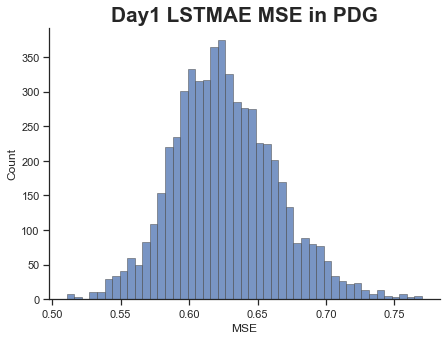

In [16]:
draw_hitogram(PDG_df, column='MSE')
plt.title('Day1 LSTMAE MSE in PDG', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./LSTMAE_PDG.jpg', dpi=400)

Text(0.5, 1.0, 'Day1 LSTMAE MSE in MOV')

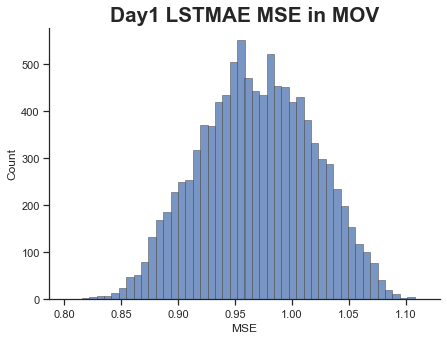

In [17]:
draw_hitogram(MOV_df, column='MSE')
plt.title('Day1 LSTMAE MSE in MOV', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./LSTMAE_MOV.jpg', dpi=400)

- 生成白噪声序列对比
- 不同时间的计算误差分布
- 对比MOV
- 使用不同的误差指标

#### 比较白噪声

In [18]:
whiteNoise = np.random.normal(0, 1, (10000, 6, config['cellNumPDG']))
whiteNoise_dataset = RespData(whiteNoise)
whiteNoise_dataloader = DataLoader(whiteNoise_dataset, batch_size=16)

In [19]:
whiteNoise_prediction = predict(whiteNoise_dataloader, Day1LSTMAE, device)

100%|██████████| 625/625 [00:06<00:00, 89.42it/s] 


In [20]:
whiteNoise_MSE = getMSE(whiteNoise, whiteNoise_prediction.numpy())
whiteNoise_df = pd.DataFrame(whiteNoise_MSE, columns=['MSE'])

Text(0.5, 1.0, 'Day1 LSTMAE MSE in White Noise')

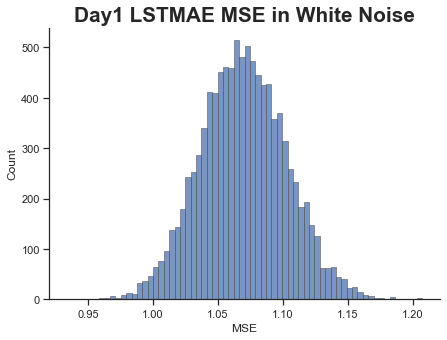

In [21]:
draw_hitogram(whiteNoise_df, column='MSE')
plt.title('Day1 LSTMAE MSE in White Noise', fontsize='xx-large',fontweight='heavy')
# plt.savefig('./LSTMAE_WhiteNoise')

#### 比对不同时间预测误差

In [22]:
def getPDGDataset(sessionData):
    repeatNum, frameNum, cellNum = sessionData.shape
    sessionData = sessionData.reshape((repeatNum*frameNum, cellNum))
    sessionData = (sessionData - np.mean(sessionData, axis=1, keepdims=True)) / np.std(sessionData, axis=1, keepdims=True)
    sessionData = sessionData.reshape((repeatNum, frameNum, cellNum))

    # split the data, stride 6, step 1
    sessionData = splitResp(sessionData)

    return sessionData

In [23]:
Respdata = io.loadmat('./Main experiments/Mouse 1/RespData.mat')
Respdata = Respdata['RespData'][0][0][0][0][0][0]

In [24]:
repeatNum, frameNum, cellNum, sessionNum = Respdata.shape
# PDG_Data = [getPDGDataset(Respdata[:, :, :, i]) for i in range(sessionNum)]
PDG_Data = [np.load(f'./myData/Mouse1/Session{i}_PDG_split_LSTM.npy') for i in range(5)]


In [25]:
PDG_Dataset = [RespData(d) for d in PDG_Data]
PDG_Dataloader = [DataLoader(dataset, batch_size=16) for dataset in PDG_Dataset]

In [26]:
PDG_Predictions = [predict(dataloader, Day1LSTMAE, device) for dataloader in PDG_Dataloader]

100%|██████████| 357/357 [00:02<00:00, 152.77it/s]


In [27]:
PDG_MSE = [getMSE(d, pred.numpy()) for d, pred in zip(PDG_Data, PDG_Predictions)]

In [28]:
PDG_df = [pd.DataFrame(mse, columns=[f'MSE Day {i*7}']) for i, mse in enumerate(PDG_MSE)]

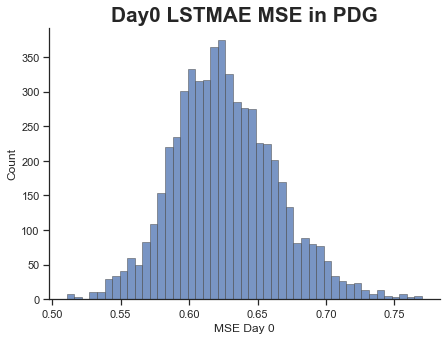

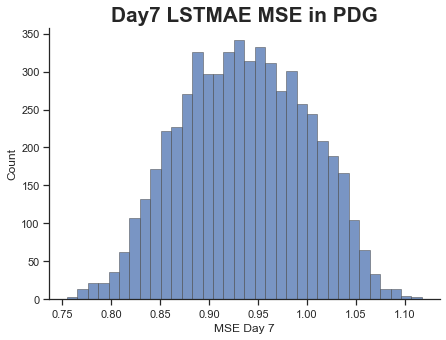

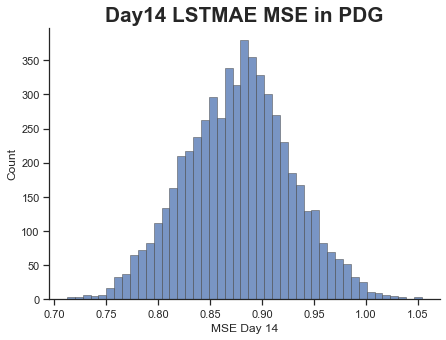

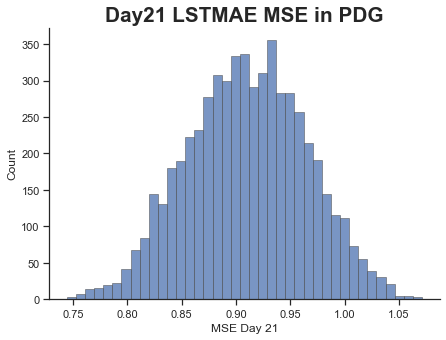

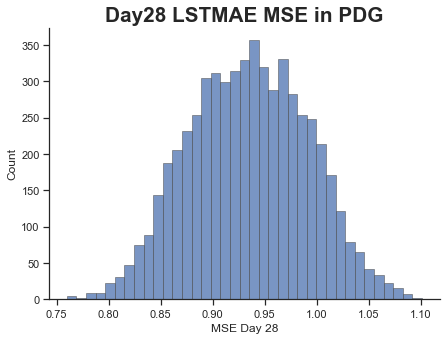

In [29]:
for i in range(5):
    draw_hitogram(PDG_df[i][PDG_df[i][f'MSE Day {i*7}'] <= 5], f'MSE Day {i*7}')
    plt.title(f'Day{i*7} LSTMAE MSE in PDG', fontsize='xx-large',fontweight='heavy')
    plt.savefig(f'LSTMAE{i}.jpg', dpi=400)

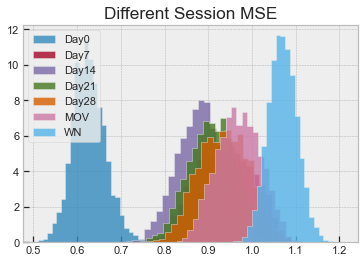

<Figure size 432x288 with 0 Axes>

In [30]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.style.use('bmh')

fig, ax = plt.subplots()
# print(PDG_df)
ax.hist(PDG_df[0]['MSE Day 0'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day0')
ax.hist(PDG_df[1]['MSE Day 7'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day7')
ax.hist(PDG_df[2]['MSE Day 14'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day14')
ax.hist(PDG_df[3]['MSE Day 21'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day21')
ax.hist(PDG_df[4]['MSE Day 28'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='Day28')
ax.hist(MOV_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
ax.hist(whiteNoise_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
ax.set_title("Different Session MSE")

ax.legend(loc='upper left')

plt.show()
plt.savefig('./LSTMAE_DAY.jpg', dpi=400)

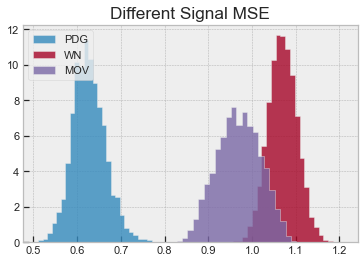

<Figure size 432x288 with 0 Axes>

In [31]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.style.use('bmh')

fig, ax = plt.subplots()
# print(PDG_df)
ax.hist(PDG_df[0]['MSE Day 0'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='PDG')
ax.hist(whiteNoise_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='WN')
ax.hist(MOV_df['MSE'], histtype="stepfilled", bins=25, alpha=0.8, density=True, label='MOV')
ax.set_title("Different Signal MSE")

ax.legend(loc='upper left')

plt.show()

plt.savefig('./LSTMAE_SIGNAL.jpg', dpi=400)